##### Numerical Computation: HW9

##### Andrew Pickner

I worked alone on this assignment.

---

In [1]:
# global imports

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def get_error(obs, truth):
    diff = np.subtract(obs, truth)
    return np.sqrt(np.linalg.norm(diff, ord=2) / np.linalg.norm(truth, ord=2))

def get_size(matrix):
    return matrix.shape[0], matrix.shape[1]

def is_symmetric(matrix):
    if matrix.shape[0] == matrix.shape[1]:
        if isinstance(matrix[0][0], float):
            return np.allclose(matrix,matrix.T, atol=1e-05)
        return np.array_equal(matrix,matrix.T)
    return False

def get_rank(matrix):
    if is_symmetric(matrix):
        return np.linalg.matrix_rank(matrix, tol=None, hermitian=True)
    return np.linalg.matrix_rank(matrix, tol=None, hermitian=False)

def get_condition_number(matrix):
    return np.linalg.cond(matrix)

# reworked a function from homework 5 where we use cholesky or LU decomp. depending on what
def NE_solve1(A,b):
    if is_symmetric(A) and get_rank(A) == get_size(A)[1]:
        print("NE used: Cholesky")
        return cholesky_solve(A,b)
    print("NE used: LU")
    return lu_solve(A,b)

# reworked a function from homework 5 where we use cholesky or LU decomp. depending on what
def NE_solve2(A,b):
    if is_symmetric(A) and get_rank(A) == get_size(A)[1]:
        print("NE used: Cholesky")
        return cholesky_solve2(A,b)
    print("NE used: LU")
    return lu_solve2(A,b)

def lu(A):
    #  n = number of rows
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    #Loop over rows
    for i in range(n):
        #Eliminate entries below i with row operations 
        #on U and reverse the row operations to 
        #manipulate L
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
    return L, U

def lu_solve(A, b):
    new_A = np.matmul(A.T, A)
    new_b = np.matmul(A.T, b)
    L, U = lu(new_A)
    # solve Ly=b for y using forward sub
    y = forward_sub(L, new_b)
    # then solve Ux=y for x using back sub
    return back_sub(U, y)
    # seemed rather consistent with the scipy method so I kept the forward and backward that I have.
    # return solve_triangular(U, b)
    
def lu_solve2(A, b):
    L, U = lu(A)
    # solve Ly=b for y using forward sub
    y = forward_sub(L, b)
    # then solve Ux=y for x using back sub
    return back_sub(U, y)
    # seemed rather consistent with the scipy method so I kept the forward and backward that I have.
    # return solve_triangular(U, b)

def cholesky(A):
    #  n = number of rows
    n = A.shape[0]
    L = np.zeros((n, n), dtype=np.double)
    for k in range(n):
        L[k, k] = np.sqrt(A[k, k] - np.sum(L[k, :] ** 2))
        L[(k+1):, k] = (A[(k+1):, k] - L[(k+1):, :] @ L[:, k]) / L[k, k]
    return L

def cholesky_solve(A, b):
    new_A = np.matmul(A.T, A)
    new_b = np.matmul(A.T, b)
    L = cholesky(new_A)
#     y = np.linalg.solve(L, new_b)
#     return np.linalg.solve(L.T, y)
    # just special case of LU decomp where U = L.T
    y = forward_sub(L, new_b)
    return back_sub(L.T, y)

def cholesky_solve2(A, b):
    L = cholesky(A)
#     y = np.linalg.solve(L, new_b)
#     return np.linalg.solve(L.T, y)
    # just special case of LU decomp where U = L.T
    y = forward_sub(L, b)
    return back_sub(L.T, y)

def forward_sub(L, b):
    #  n = number of rows
    n = L.shape[0]
    # allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
    return y

def back_sub(U, y):
    #  n = number of rows
    n = U.shape[0]
    # allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);
    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
    return x

# 1 NE
def NE_solver1(A, b):
    return NE_solve1(A,b) 

def NE_solver2(A, b):
    new_A = np.matmul(A.T, A)
    new_b = np.matmul(A.T, b)
    return NE_solve1(new_A,new_b) 
    
# 2 QR
def QR_solver(A, b):
    Q, R = np.linalg.qr(A)
    return np.linalg.solve(R, Q.T.dot(b))

---
### 1: Consider the function: $f(x) = sin(2\pi x) + cos(3\pi x)$


Compute the coefficients of a least-squares-fit degree-7 polynomial from $n = 33$ evenly spaced points. In other words, your training data are pairs $(x_i, y_i)$ with $i = 1,\ .\ .\ .\ , 33$ where the $x_i$’s are evenly spaced points in $[−1,1]$ (like, `linspace`) and $y_i = f(x_i)$. Make a plot of both $f(x)$ and the degree-7 polynomial approximation.

---

In [3]:
f = lambda x: np.sin(2 * np.pi * x) + np.cos(3 * np.pi * x)

In [4]:
num_points = 33
interval = -1, 1

xs = np.linspace(interval[0], interval[1], num=num_points)

In [5]:
# degree of p(x)
d = 7

# vandermonde matrix to represent our over-determined system
A = np.vander(xs, N=d+1, increasing=True)

# actual values of f(x) that were trying to approximate
ys = np.array([f(x) for x in xs])

# our coefficients for the polynomial of
cs = np.linalg.lstsq(A, ys, rcond=None)[0]

In [6]:
def f_tilde(cs, x):
    return sum([cs[i] * (x ** i) for i in range(len(cs))])

In [7]:
approx = [f_tilde(cs, x) for x in xs]

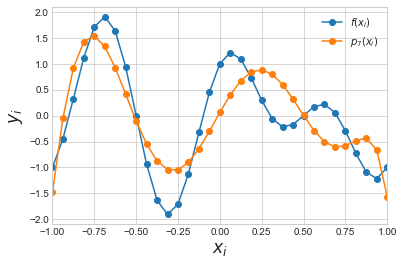

In [8]:
plt.plot(xs, ys, '-o', label='$f(x_{i})$')
plt.plot(xs, approx, '-o', label='$p_{7}(x_{i})$')
plt.xlim([interval[0], interval[1]])
plt.xlabel("$x_{i}$", fontsize='xx-large')
plt.ylabel("$y_{i}$", fontsize='xx-large')
plt.legend()

---
### 2: Create testing data: 


(i) choose $100$ random points in the interval $[−1, 1]$.
(ii) evaluate the function at each of those points. This gives you a new set of data: $(x_{1}^{'},\ y_{1}^{'}),\ .\ .\ .\ ,\ (x_{100}^{'},y_{100}^{'})$.

For $d$ from $1$ to $31$, compute the least-squares coefficients of a polynomial of degree d with the same training data as in the last problem using both the QR method and the normal equations.
For each trained polynomial $p_{d}(x)$, compute the normalized testing error:

$e_d = (\frac{\Sigma_{i=1}^{100}(y_{i}^{'} - p(x_{i}^{'}))^2}{\Sigma_{i=1}^{100} (y_{i}^{'})^2})^{\frac{1}{2}}$

Plot the error $e_d$ versus $d$ on a log scale (that is, use semilogy). Make sure to include both (i) the error computed using the QR decomposition and (ii) the error computed using the normal equations. Interpret the error behavior.

---

In [9]:
def generate_random_xs(low=-1, high=1, n=100):
    l1 = np.append(np.array([low]), low * np.random.rand(n//2 - 1))
    l2 = np.append(np.array([high]), high * np.random.rand(n//2 - 1))
    ret = np.append(l1, l2)
    return np.sort(ret)

In [10]:
new_size = 100 

# i
new_xs = generate_random_xs()

# ii
new_ys = np.array([f(x) for x in new_xs])

In [11]:
d_upper = 31

qr_error = []
ne_error = []

for i in range(1, d_upper + 1):
    print(i)
    ai = np.vander(new_xs, N=i+1, increasing=True)
    
    qr_cs   = QR_solver(ai, new_ys)
    ne_cs   = NE_solver1(ai, new_ys)
    
    qr_approx = [f_tilde(qr_cs, x) for x in new_xs]
    ne_approx = [f_tilde(ne_cs, x) for x in new_xs]
    
    qr_error.append(get_error(qr_approx, new_ys))
    ne_error.append(get_error(ne_approx, new_ys))

1
NE used: LU
2
NE used: LU
3
NE used: LU
4
NE used: LU
5
NE used: LU
6
NE used: LU
7
NE used: LU
8
NE used: LU
9
NE used: LU
10
NE used: LU
11
NE used: LU
12
NE used: LU
13
NE used: LU
14
NE used: LU
15
NE used: LU
16
NE used: LU
17
NE used: LU
18
NE used: LU
19
NE used: LU
20
NE used: LU
21
NE used: LU
22
NE used: LU
23
NE used: LU
24
NE used: LU
25
NE used: LU
26
NE used: LU
27
NE used: LU
28
NE used: LU
29
NE used: LU
30
NE used: LU
31
NE used: LU


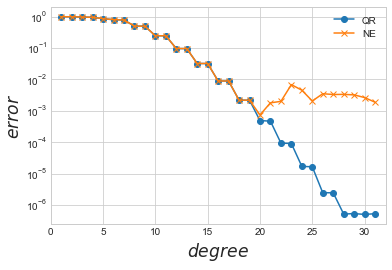

In [12]:
k = [n for n in range(1, d_upper + 1)]
plt.semilogy(k, qr_error, '-o', label='QR')
plt.semilogy(k, ne_error, '-x', label='NE')

plt.xlim([0, d_upper + 1])
plt.xlabel("$degree$", fontsize='xx-large')
plt.ylabel("$error$", fontsize='xx-large')
plt.legend()

In [13]:
d_upper = 31

qr_error = []
ne_error = []

for i in range(1, d_upper + 1):
    print(i)
    ai = np.vander(new_xs, N=i+1, increasing=True)
    
    qr_cs   = QR_solver(ai, new_ys)
    ne_cs   = NE_solver2(ai, new_ys)
    
    qr_approx = [f_tilde(qr_cs, x) for x in new_xs]
    ne_approx = [f_tilde(ne_cs, x) for x in new_xs]
    
    qr_error.append(get_error(qr_approx, new_ys))
    ne_error.append(get_error(ne_approx, new_ys))

1
NE used: Cholesky
2
NE used: Cholesky
3
NE used: Cholesky
4
NE used: Cholesky
5
NE used: Cholesky
6
NE used: Cholesky
7
NE used: Cholesky
8
NE used: Cholesky
9
NE used: Cholesky
10
NE used: Cholesky
11
NE used: Cholesky
12
NE used: Cholesky
13
NE used: Cholesky
14
NE used: Cholesky
15
NE used: Cholesky
16
NE used: Cholesky
17
NE used: Cholesky
18
NE used: Cholesky
19
NE used: Cholesky
20
NE used: LU
21
NE used: LU
22
NE used: LU
23
NE used: LU
24
NE used: LU
25
NE used: LU
26
NE used: LU
27
NE used: LU
28
NE used: LU
29
NE used: LU
30
NE used: LU
31
NE used: LU


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt


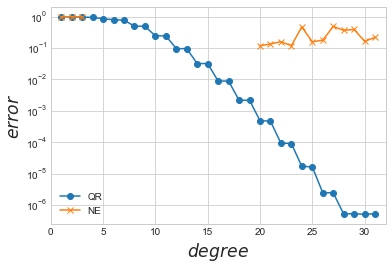

In [14]:
k = [n for n in range(1, d_upper + 1)]
plt.semilogy(k, qr_error, '-o', label='QR')
plt.semilogy(k, ne_error, '-x', label='NE')

plt.xlim([0, d_upper + 1])
plt.xlabel("$degree$", fontsize='xx-large')
plt.ylabel("$error$", fontsize='xx-large')
plt.legend()

---
### Interpretation:

So initially, I had my own Cholesky method working, but it was only going up to around degree 7 or before returning lists of `nan`'s. Hmm... I tweaked the Cholesky method to use numpy's implementation but was getting positive definite error (I assume because I was using $A^{T}A$?)... Then, I remembered  HW5 where we implemented Cholesky/LU (my method depends on symmetry), but I added the line that I had from HW8 where the rank also has to match # of columns. My error plot reproduced yours reasonably close (although, you said you made a mistake on Piazza, so now I question this...), however upon further investigation, my NE solver now uses LU decomp exclusively. I tweaked this implementation to get `NE_Solver2`, which was a shitshow, and I apologize for the mess above... It appeared to let Cholesky run up until degree 20, but the error plot implies (without me actually checking because I am eager to attempt the bonus question) that we were returning a `[nan, ... , nan]` :/

Sorta weird.

---

---

### BONUS

Here some US COVID case counts from back in March:

Days since Feb 29 | Case count
------------------|------------
1                 | 89
2                 | 105
3                 | 125
4                 | 159
5                 | 227
6                 | 331
7                 | 444
8                 | 564
9                 | 728
10                | 1000
11                | 1267
12                | 1645
13                | 2204
14                | 2826
15                | 3485
17                | 7038

Derive the linear least-squares system whose solution contains the coefficients of a log-linear model for case count over time. Plot the data on top of the model on a log scale. How well does the log-linear model (which represents exponential growth) appear to model the growth in the case count? What was the case doubling time over this roughly two week period?

---

Essentially, we are going to need to 'linearize' a exponential model: $y=c_{1}e^{c_2\cdot t}$.

We can do this like so: $ln(y) = ln(c_{1}) + c_{2}\cdot t = k + c_{2}\cdot t$

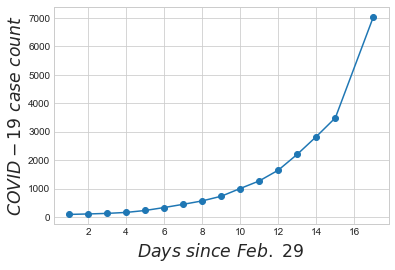

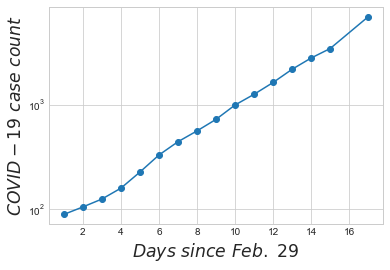

In [15]:
days_since_feb_29 = [day for day in range(1, 16)] + [17]
case_count        = [89, 105, 125, 159, 227, 331, 444, 564, 728, 1000, 1267, 1645, 2204, 2826, 3485, 7038]

plt.plot(days_since_feb_29, case_count,  '-o')
plt.xlabel("$Days\ since\ Feb.\ 29$", fontsize='xx-large')
plt.ylabel("$COVID-19\ case\ count$", fontsize='xx-large')
plt.show()
plt.semilogy(days_since_feb_29, case_count,  '-o')
plt.xlabel("$Days\ since\ Feb.\ 29$", fontsize='xx-large')
plt.ylabel("$COVID-19\ case\ count$", fontsize='xx-large')
plt.show()

In [16]:
b = np.array([np.log(y) for y in case_count])
print(b)
A = np.array([[float(1), float(x)] for x in days_since_feb_29])
print(A)

[4.48863637 4.65396035 4.82831374 5.0689042  5.42495002 5.80211838
 6.09582456 6.33505425 6.59030105 6.90775528 7.14440718 7.40549566
 7.69802917 7.94661756 8.15622332 8.85907932]
[[ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 1. 17.]]


In [17]:
print(NE_solver1(A, b))

NE used: LU
[4.0920173  0.27688609]


In [18]:
print(QR_solver(A, b))

[4.0920173  0.27688609]


In [19]:
print(np.linalg.lstsq(A, b, rcond=None)[0])

[4.0920173  0.27688609]


In [20]:
print(np.exp(4.0920173))

59.860526625182786


---

All three solvers produce the same output, thus we can proceed and solve $k$ for $c_1$:

$c_1 \approx e^{k}$

$c_1 \approx e^{4.0920173}$

$c_1 \approx 59.8605266$

---

In [21]:
approx_f = lambda t: 59.8605266 * np.exp(0.27688609 * t)

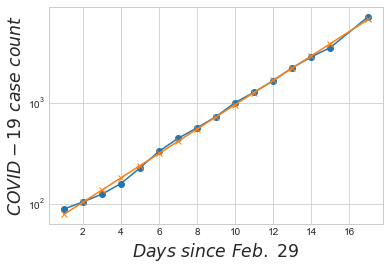

In [22]:
approx = [approx_f(x) for x in days_since_feb_29]

plt.semilogy(days_since_feb_29, case_count,  '-o')
plt.semilogy(days_since_feb_29, approx,  '-x')

plt.xlabel("$Days\ since\ Feb.\ 29$", fontsize='xx-large')
plt.ylabel("$COVID-19\ case\ count$", fontsize='xx-large')
plt.show()

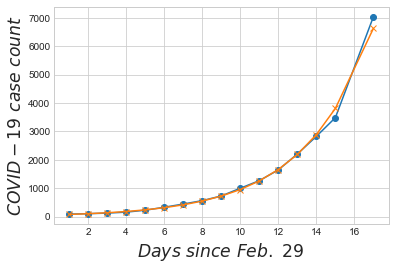

In [23]:
approx = [approx_f(x) for x in days_since_feb_29]

plt.plot(days_since_feb_29, case_count,  '-o')
plt.plot(days_since_feb_29, approx,  '-x')

plt.xlabel("$Days\ since\ Feb.\ 29$", fontsize='xx-large')
plt.ylabel("$COVID-19\ case\ count$", fontsize='xx-large')
plt.show()

---


For starters, I always like to see the data on a log and linear scale. The log-linear model appears to model the growth of COVID-19 cases extremely well for the first two weeks and we find a tiny bit of error as we extend into the last few data points, but overall, this seems like a great model.

The simple way I remember calculating half life is by setting the equation we have above: $y = 59.8605266\cdot e^{0.27688609\cdot t}$ into $2 = e^{0.27688609\cdot t}$. Which, can be further simplified into: $\frac{ln(2)}{0.27688609}=t$.

So the doubling time turns out to around 2 and a half days, and this seems to check out when looking at the data: it appears to double every 2 or 3 days.

---

In [24]:
print(np.log(2) / 0.27688609)

2.503365844632879
